![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Copyright:** 2025 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Micheal Schick (EUMETSAT), Serena Avolio (EUMETSAT/Starion)

<div class="alert alert-block alert-success">
<h3>Destination Earth - Weather-Induced Extremes DT Parameter Plotter Tutorial</h3></div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
   <li>To search and access DT data an <a href="https://platform.destine.eu/support-pages/access-policy/"> upgraded access</a> is needed.</li>
<b> References: </b>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Use-of-Harmonized-Data-Access/Use-of-Harmonized-Data-Access.html">DestinE Data Lake (DEDL) Harmonized Data Access (HDA) documentation</a> </li>
    <li> <a href="https://destine.ecmwf.int/weather-induced-extremes-digital-twin-1/">Weather-Induced Extremes Digital Twin (Extremes DT)</a></li>
    <li> <a href="https://confluence.ecmwf.int/display/DDCZ/Extremes+DT+data+catalogue">Extreme DT data catalogue</a></li>
<b> Credit: </b>
    <li> Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (ECMWF).</li>
</div>


This notebook demonstrates how to use the **HDA (Harmonized Data Access)** API to query and access Extremes DT data.

A correct combination of parameters is necessary to access DT data.
The aim of this notebook is to help you create the correct request to access the desired Extremes DT data, through HDA, and visualize it.

Below the main steps covered by this tutorial.

1. [Setup](ExtremeDT-ParameterPlotter.ipynb#Setup): Import the required libraries and define some function. 
2. [Parameter Selection](ExtremeDT-ParameterPlotter.ipynb#Parameter-Selection): How to select the desired Extreme DT variable and check its characteristics. 
3. [Datetime Selection](ExtremeDT-ParameterPlotter.ipynb#Date-Selection):  How to select the desired date and time. 
4. [Levels Selection](ExtremeDT-ParameterPlotter.ipynb#Levels-Selection): How to Handle different Levels to be selected (if any).
5. [Order and Download](ExtremeDT-ParameterPlotter.ipynb#Order-and-Download): How to order and download Climate DT data.
6. [Plot](ExtremeDT-ParameterPlotter.ipynb#EarthKit): How to visualize hourly data on single levels data through Earthkit.

# Setup

Import the Climate DT parameters & scenarios dictionary and all the required packages.

In [1]:
import destinelab as deauth
from destinelab import extreme_dt_dictionary
import ipywidgets as widgets
import json
import datetime
import importlib.metadata

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import os
from getpass import getpass
from tqdm import tqdm
import time
from urllib.parse import unquote
from time import sleep
from IPython.display import JSON
from datetime import datetime, timedelta

Define some useful funtions to simplify the parameters selection.

In [2]:
def filter_entries(search_string):
    return [(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params) if search_string.lower() in entry['paramName'].lower()]

def on_search_change(change):
    search_string = change.new
    if search_string:
        filtered_options = filter_entries(search_string)
        entry_dropdown.options = filtered_options
    else:
        entry_dropdown.options = [(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params)]
        
def get_selected_entry():
    return entry_dropdown.value

def on_scenario_change(change):
    print("scenario_change")
    selected_index = change.new
    selected_entry = extreme_dt_dictionary.extremeDT_scenario[selected_index]
    start_date_picker.min = date_from
    start_date_picker.max = date_to
    # Set the initial date of the start_date_picker to the scenario's start date
    start_date_picker.value = date_to
    selected_start_date = start_date_picker.value
    
def get_selected_values():
    selected_scenario_index = scenario_dropdown.value
    selected_scenario = extreme_dt_dictionary.extremeDT_scenario[selected_scenario_index]
    selected_start_date = start_date_picker.value
    return selected_scenario_index, selected_scenario, selected_start_date

def parse_input_string(input_string):
    ranges = input_string.split('/')
    step_start = ""
    step_end = ""
    step_width = 1
    hypen = ""
    options = []
    for rng in ranges:
        if rng:
            if '-' in rng:
                hypen = "-"
                start, end = rng.split('-')
                step_width = int(end) - int(start)
                if step_start == "":
                    step_start = int(start.strip())
                step_end = int(end.strip())
            elif 'to' not in rng:
                if step_start == "":
                    step_start = int(rng.strip())
                step_end = int(rng.strip())
                #options.append(option)
    #print(str(step_start) + ":" + str(step_end))
    if hypen != "":
        options.extend([f"{i}-{i+step_width}" for i in range(step_start, step_end, step_width)])
    else:
        options.extend([f"{i}" for i in range(step_start, step_end+1, step_width)])
    return options

def get_selected_step_values():
    selected_values = multi_select.value
    selected_values_string = "/".join(selected_values)
    return selected_values_string

# Function to convert tuple or single integer to string separated by "/"
def convert_to_string(input):
    if isinstance(input, tuple):
        return '/'.join(map(str, input))
    elif isinstance(input, int):
        return str(input)
    else:
        return None  # Handle other types if needed


# Parameter Selection

Extreme DT variable selection (we limit the plotting to one variable)

In [3]:
# Create search box
search_box = widgets.Text(placeholder='Search by parameter name', description='Search:', disabled=False)

# Create dropdown to select entry
entry_dropdown = widgets.Dropdown(
    options=[(entry['paramName'], i) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_params)],
    description='Select Entry:'
)

search_box.observe(on_search_change, names='value')

# Display widgets
display(search_box, entry_dropdown)



Text(value='', description='Search:', placeholder='Search by parameter name')

Dropdown(description='Select Entry:', options=(('Sea ice area fraction', 0), ('Sea surface temperature', 1), (…

Let's see the  details of the selected parameter (Polytope convention).

From the details it is possible to see the parameter characteristic as the time resolution and the models with which the parameter can be obtained. 

In [4]:

selected_index = get_selected_entry()
selected_entry = extreme_dt_dictionary.extremeDT_params[selected_index]
print(json.dumps(selected_entry,indent=4))

{
    "param": "167",
    "paramName": "2 metre temperature",
    "shortName": "2t",
    "unit": "K",
    "encoding": "instantaneous",
    "stream": "oper",
    "type": "fc",
    "levtype": "sfc",
    "step": "0/1/to/96",
    "levelist": ""
}


# Datetime Selection

Extreme DT data is available for specific time ranges (last 14 days) around the current date.

It is possible to use the ECMWF Aviso package to check data availability in the last 14 days (see https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/HDA/DestinE%20Digital%20Twins/ExtremeDT-dataAvailability.ipynb or https://github.com/destination-earth-digital-twins/aviso-examples/blob/main/aviso-extremes-dt.py) and request data accordingly.

In [5]:
from datetime import datetime, timedelta

# Get the current date and time in UTC
current_date = datetime.utcnow()

# Calculate the date 15 days before the current date
date_14_days_ago = current_date - timedelta(days=14)

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = date_14_days_ago.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_from = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

# Format the date as YYYYMMDD and set the time to 0000 UTC
formatted_date = current_date.strftime('%Y%m%d') + '0000'
# Convert the formatted date back to a datetime object
date_to = datetime.strptime(formatted_date, '%Y%m%d%H%M%S').date()

In [6]:
from ipywidgets import Label
# Create dropdown to select scenario
scenario_dropdown = widgets.Dropdown(
    options=[(f"{entry['model']}", (i)) for i, entry in enumerate(extreme_dt_dictionary.extremeDT_scenario)],
    description='Scenario:'
)

# Create date picker widgets
start_date_picker = widgets.DatePicker(description='Start Date:', disabled=False) 
scenario_dropdown.observe(on_scenario_change, names='value')

# Set initial values directly
selected_entry = extreme_dt_dictionary.extremeDT_scenario[0]

# Set initial values directly
start_date_picker.min = date_from
start_date_picker.max = date_to
start_date_picker.value = date_to

# Display widgets
display(Label("To choose your date, please consider the current Extremes DT data availability (ExtremeDT-dataAvailability.ipynb in this folder)."),scenario_dropdown,  start_date_picker)

# Example usage:
selected_scenario_index, selected_scenario, selected_start_date = get_selected_values()


Label(value='To choose your date, please consider the current Extremes DT data availability (ExtremeDT-dataAva…

Dropdown(description='Scenario:', options=(('IFS-NEMO', 0),), value=0)

DatePicker(value=datetime.date(2025, 8, 6), description='Start Date:', max=datetime.date(2025, 8, 6), min=date…

## Steps (hours) selection

Step selection within the observation to be retrieved (one step usually one hour)

In [7]:
selected_entry = extreme_dt_dictionary.extremeDT_params[selected_index]
input_string = selected_entry["step"]

options = parse_input_string(input_string)

multi_select = widgets.SelectMultiple(
    options=options,
    description='Select (Steps):',
    disabled=False
)

display(multi_select)

SelectMultiple(description='Select (Steps):', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',…

# Levels Selection

Handle different Levels to be selected (if any)

In [8]:
# Define a global variable
global global_widget
global_widget = None

if selected_entry["levelist"] != "":
    # Convert levelist string to list of integers
    levelist = list(map(int, selected_entry["levelist"].split('/')))
      
    # Create a function to generate the widget based on the selection mode
    def generate_widget(selection_mode):
        global global_widget
        if selection_mode == 'Single':
            global_widget = widgets.Dropdown(options=levelist, description='Select level:')
            return global_widget
        elif selection_mode == 'Multiple':
            global_widget = widgets.SelectMultiple(options=levelist, description='Select levels:')
            return global_widget

    # Create a dropdown widget to choose selection mode
    selection_mode_dropdown = widgets.Dropdown(options=['Single', 'Multiple'], description='Selection Mode:')

    # Create an output widget to display the selected option(s)
    output = widgets.Output()

    # Function to display the widget based on the selection mode
    def display_widget(selection_mode):
        output.clear_output()
        with output:
            display(generate_widget(selection_mode))

    # Define a function to handle the change in selection mode
    def on_dropdown_change(change):
        display_widget(change.new)

    # Register the function to handle dropdown changes
    selection_mode_dropdown.observe(on_dropdown_change, names='value')

    # Display the widgets
    display(selection_mode_dropdown, output)

    # Display the initial widget based on default selection mode
    display_widget('Single')

## Convert selected parameters and levels into HDA request
Convert levels (if any)

In [9]:
levlInput = ""
if global_widget != None:
    # Test cases
    levlInput = convert_to_string(global_widget.value)

In [16]:
# Call get_selected_values after the display is finished
selected_step_values = get_selected_step_values()

# Print the result in JSON format
#datechoice = get_selected_values()[2].strftime('%Y%m%d')
datechoice = "{fname}T00:00:00Z".format(fname = get_selected_values()[2])

filter_params = {
  "class": "d1",                       # fixed 
  "dataset": "extremes-dt",             # fixed extreme-dt access
  "expver": "0001",                    # fixed experiment version 
  "stream": selected_entry["stream"],
  "type": "fc",                        # fixed forecasted fields
#  "date": datechoice,                  # choose the date
  "time": "0000",                      # fixed 
  "step": selected_step_values,        # step choice 
  "levtype": selected_entry["levtype"],  
  "levelist": str(levlInput),  
  "param": str(selected_entry["param"]),  
}

# Print the result in JSON format
print(datechoice)
print(json.dumps(filter_params, indent=4))
hdaFilters = {
    key: {"eq": value}
    for key, value in filter_params.items()
}

#print(json.dumps(hdaFilters, indent=4))

2025-08-06T00:00:00Z
{
    "class": "d1",
    "dataset": "extremes-dt",
    "expver": "0001",
    "stream": "oper",
    "type": "fc",
    "time": "0000",
    "step": "0/1",
    "levtype": "sfc",
    "levelist": "",
    "param": "167"
}


# Order and Download

## Obtain Authentication Token

To perform our request we need to be authenticated. 
Below to request of an authentication token.

In [11]:
DESP_USERNAME = input("Please input your DESP username: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


### Check if DT access is granted

If DT access is not granted, you will not be able to execute the rest of the notebook.

In [12]:
import importlib
installed_version = importlib.metadata.version("destinelab")
version_number = installed_version.split('.')[1]
if((int(version_number) >= 8 and float(installed_version) < 1) or float(installed_version) >= 1):
    auth.is_DTaccess_allowed(access_token)

DT Output access allowed


## HDA Endpoint
HDA API is based on the Spatio Temporal Asset Catalog specification (STAC), it is convenient define a costant with its endpoint.
And another one with the ID of the Cliamte DT collection.

In [13]:
HDA_STAC_ENDPOINT="https://hda.data.destination-earth.eu/stac/v2"
COLLECTION_ID="EO.ECMWF.DAT.DT_EXTREMES"

### Filtering

Search into asynchronous datasets, as the DTs are, always return a single item:

In [17]:
#Sometimes requests to polytope get timeouts, it is then convenient define a retry strategy
retry_strategy = Retry(
    total=5,  # Total number of retries
    status_forcelist=[500, 502, 503, 504],  # List of 5xx status codes to retry on
    allowed_methods=["GET",'POST'],  # Methods to retry
    backoff_factor=1  # Wait time between retries (exponential backoff)
)

# Create an adapter with the retry strategy
adapter = HTTPAdapter(max_retries=retry_strategy)

# Create a session and mount the adapter
session = requests.Session()
session.mount("https://", adapter)

response = session.post(HDA_STAC_ENDPOINT+"/search", headers=auth_headers, json={
 "collections": [COLLECTION_ID],
    "datetime": datechoice,
    "query": hdaFilters
})

if(response.status_code!= 200):
    (print(response.text))
response.raise_for_status()

product = response.json()["features"][0]
JSON(product)

<IPython.core.display.JSON object>

The single item returned (above) contains:
- The product id: "DT_EXTREMES_ORDERABLE_...", that is a placeholder, its name contains the term "ORDERABLE".
- The storage:tier that indicates that the product is "offline"
- The order:status that indicates that the product is "orderable"
- Request params used for the order extracted from the search result

In [18]:
ecmwf_properties = {
    key: value for key, value in product.get('properties', {}).items()
    if key.startswith('ecmwf:')
}

## Order data

We have now all the information to order the data.

From the search results we know that the product is orderable and offline, we then need to order the product we searched for.

In [19]:
response = requests.post(f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/order", json=ecmwf_properties, headers=auth_headers)

if response.status_code != 200:
    print(response.content)
response.raise_for_status()

ordered_item = response.json()

product_id = ordered_item["id"]
storage_tier = ordered_item["properties"].get("storage:tier", "online")
order_status = ordered_item["properties"].get("order:status", "unknown")
federation_backend = ordered_item["properties"].get("federation:backends", [None])[0]

print(f"Product ordered: {product_id}")
print(f"Provider: {federation_backend}")
print(f"Storage tier: {storage_tier} (product must have storage tier \"online\" to be downloadable)")
print(f"Order status: {order_status}")    

Product ordered: 530c13b1-f915-4717-bbab-716a040281b4
Provider: dedt_lumi
Storage tier: offline (product must have storage tier "online" to be downloadable)
Order status: shipping


### Poll the API until product is ready

We request the product itself to get an update of its status.

In [20]:
#timeout and step for polling (sec)
TIMEOUT = 300
STEP = 1
ONLINE_STATUS = "online"

self_url = f"{HDA_STAC_ENDPOINT}/collections/{COLLECTION_ID}/items/{product_id}"
item = {}

for i in range(0, TIMEOUT, STEP):
    print(f"Polling {i + 1}/{TIMEOUT // STEP}")

    response = requests.get(self_url, headers=auth_headers)
    if response.status_code != 200:
        print(response.content)
    response.raise_for_status()
    item = response.json()

    storage_tier = item["properties"].get("storage:tier", ONLINE_STATUS)

    if storage_tier == ONLINE_STATUS:
        download_url = item["assets"]["downloadLink"]["href"]
        print("Product is ready to be downloaded.")
        print(f"Asset URL: {download_url}")
        break

    sleep(STEP)
else:
    order_status = item["properties"].get("order:status", "unknown")
    print(f"We could not download the product after {TIMEOUT // STEP} tries. Current order status is {order_status}")
    


Polling 1/300
Polling 2/300
Product is ready to be downloaded.
Asset URL: https://hda-download.central.data.destination-earth.eu/data/dedt_lumi/EO.ECMWF.DAT.DT_EXTREMES/530c13b1-f915-4717-bbab-716a040281b4/downloadLink


# Download

In [21]:
response = requests.get(download_url, stream=True, headers=auth_headers)
response.raise_for_status()

content_disposition = response.headers.get('Content-Disposition')
total_size = int(response.headers.get("content-length", 0))
if content_disposition:
    filename = content_disposition.split('filename=')[1].strip('"')
    filename = unquote(filename)
else:
    filename = os.path.basename(url)

# Open a local file in binary write mode and write the content
print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

downloading 530c13b1-f915-4717-bbab-716a040281b4.grib


104MB [00:10, 10.3MB/s] 


## EarthKit

Lets plot the result file with [EarthKit](https://earthkit.readthedocs.io/en/latest/index.html) selecting only the Europe area in the plot.

In [22]:
import earthkit.data
import earthkit.maps
import earthkit.regrid

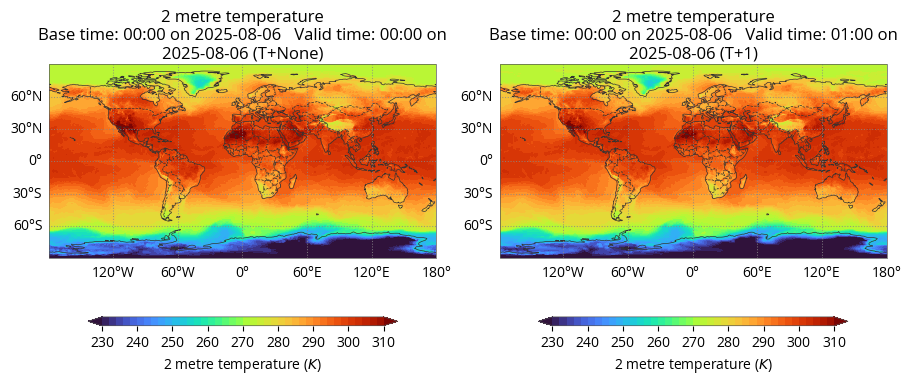

In [23]:
data = earthkit.data.from_source("file", filename)
data.ls

earthkit.maps.quickplot(data, #style=style
                       )